<a href="https://colab.research.google.com/github/ravi-maithrey/gesture-recognizer/blob/main/ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [00:11<00:00, 102MB/s] 
100% 1.03G/1.03G [00:11<00:00, 95.8MB/s]


In [ ]:
!unzip asl-alphabet.zip

In [ ]:
%cd /content/

/content


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
all = os.listdir("/content/asl_alphabet")

In [ ]:
os.chdir("/content/asl_alphabet")
if os.path.isdir('train') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in all:
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 100)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 50)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [ ]:
target_size = (200, 200)
target_dims = (200, 200, 3) # add channel for RGB
n_classes = 29
val_frac = 0.1
batch_size = 64

In [ ]:
data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

In [ ]:
train_path = "/content/asl_alphabet/train"
valid_path = "/content/asl_alphabet/valid"
test_path = "/content/asl_alphabet/test"

In [ ]:
train_batches = data_augmentor.flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=128)

valid_batches = data_augmentor.flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=64)

test_batches = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=64, shuffle=False)

Found 82650 images belonging to 29 classes.
Found 2900 images belonging to 29 classes.
Found 1450 images belonging to 29 classes.


In [ ]:
my_model = Sequential()
my_model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=(224,224,3)))
my_model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
my_model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
my_model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dense(n_classes, activation='softmax'))

my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 221, 221, 64)      3136      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      65600     
_________________________________________________________________
dropout (Dropout)            (None, 109, 109, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 106, 106, 128)     131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 52, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 49, 49, 256)       5

In [ ]:
history = my_model.fit_generator(train_batches, epochs=5, validation_data=valid_batches)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
646/646 [==============================] - 636s 966ms/step - loss: 1.4711 - accuracy: 0.5464 - val_loss: 0.4011 - val_accuracy: 0.8717
Epoch 2/5
646/646 [==============================] - 617s 955ms/step - loss: 0.4345 - accuracy: 0.8509 - val_loss: 0.1959 - val_accuracy: 0.9397
Epoch 3/5
646/646 [==============================] - 618s 956ms/step - loss: 0.2475 - accuracy: 0.9137 - val_loss: 0.1278 - val_accuracy: 0.9541
Epoch 4/5
646/646 [==============================] - 617s 955ms/step - loss: 0.1778 - accuracy: 0.9381 - val_loss: 0.1259 - val_accuracy: 0.9559
Epoch 5/5
646/646 [==============================] - 617s 955ms/step - loss: 0.1391 - accuracy: 0.9518 - val_loss: 0.1003 - val_accuracy: 0.9638


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


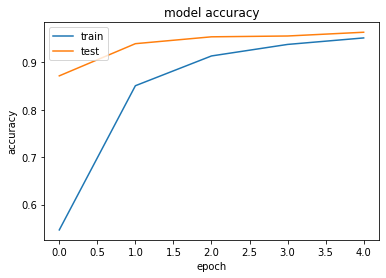

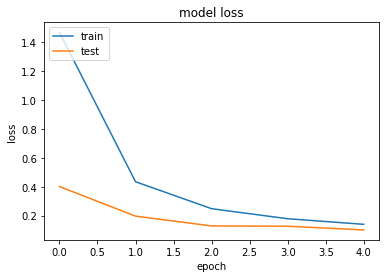

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
my_model.evaluate(test_batches)

23/23 [==============================] - 8s 330ms/step - loss: 0.0918 - accuracy: 0.9717


[0.09184221923351288, 0.9717241525650024]

In [ ]:
my_model.save('saved_model/my_model')

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [ ]:
new_model.summary()

In [ ]:
aa = test_batches.class_indices.keys()

In [ ]:
test_labels = test_batches.classes
predictions = my_model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [ ]:
aa

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'])

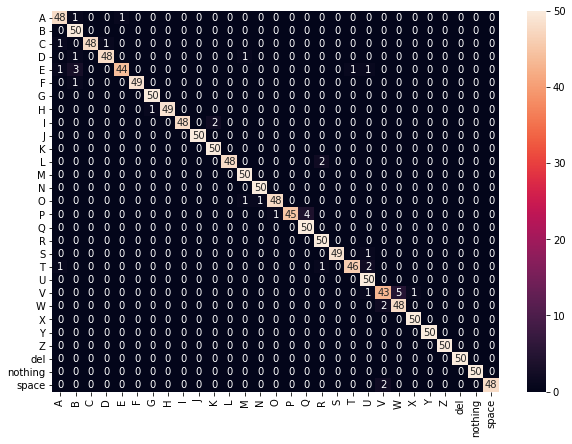

In [ ]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(cm, index = [i for i in aa],columns = [i for i in aa])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [ ]:
all = os.listdir("/content/asl_alphabet")

In [ ]:
os.chdir("/content/asl_alphabet")
if os.path.isdir('train') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in all:
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 300)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 100)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [ ]:
train_path = "/content/asl_alphabet/train"
valid_path = "/content/asl_alphabet/valid"
test_path = "/content/asl_alphabet/test"

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=256)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=64)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=64, shuffle=False)

Found 75400 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 2900 images belonging to 29 classes.


In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

In [ ]:
x = mobile.layers[-6].output

In [ ]:
output = Dense(units=29, activation='softmax')(x)

In [ ]:
model = Model(inputs=mobile.input, outputs=output)

In [ ]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history  = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=10,
            verbose=1
)

Epoch 1/10
295/295 [==============================] - 177s 601ms/step - loss: 0.2891 - accuracy: 0.9470 - val_loss: 0.0434 - val_accuracy: 0.9978
Epoch 2/10
295/295 [==============================] - 163s 553ms/step - loss: 0.0133 - accuracy: 0.9997 - val_loss: 0.0095 - val_accuracy: 0.9998
Epoch 3/10
295/295 [==============================] - 161s 545ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9999
Epoch 4/10
295/295 [==============================] - 158s 537ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 5/10
295/295 [==============================] - 159s 539ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/10
295/295 [==============================] - 159s 537ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/10
295/295 [==============================] - 164s 556ms/step - loss: 8.2591e-04 - accuracy: 1.0000 - val_loss: 0.00

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


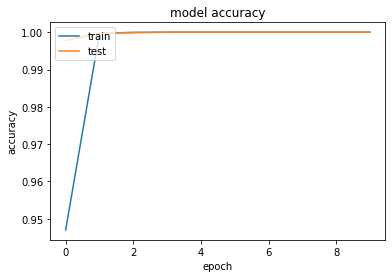

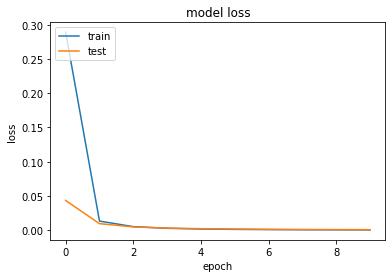

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


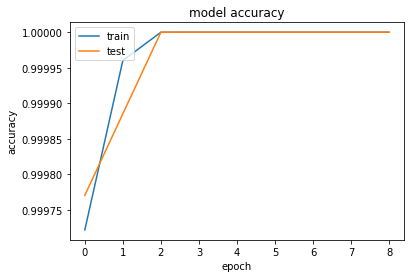

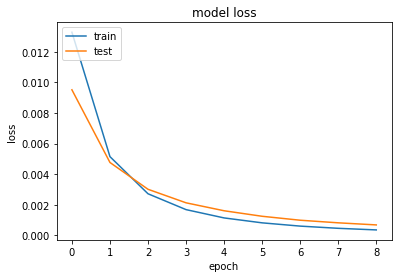

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'][1:])
plt.plot(history.history['val_accuracy'][1:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
test_labels = test_batches.classes

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

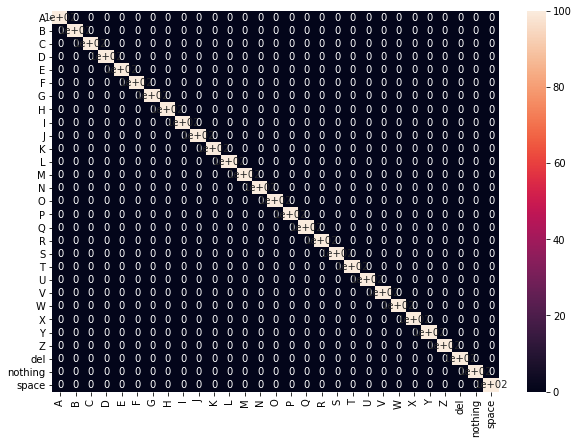

In [ ]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(cm, index = [i for i in aa],columns = [i for i in aa])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_batches.class_indices

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

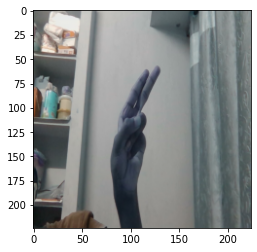

In [ ]:
img_file = cv2.imread("/content/2021-05-29-224054.jpg")
img_file = skimage.transform.resize(img_file, (224, 224, 3))
img_arr = np.asarray(img_file)
#img_arr = np.fliplr(img_arr)
plt.imshow(img_arr)
img_arr = img_arr.reshape(-1,224,224,3)

In [ ]:
ans = model.predict(img_arr)
np.argmax(ans)

12

In [ ]:
import skimage
from skimage.transform import resize

In [ ]:
%cd /content/
model.save('final_model')

/content
INFO:tensorflow:Assets written to: final_model/assets


In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
!cp -r /content/final_model/   /mydrive/ 

In [ ]:
# img = cv2.imread("./asl/asl_alphabet_test/asl_alphabet_test/A_test.jpg")
# print(img.shape)
imgs,labels = next(val_generator)
print([np.argmax(i) for i in new_model.predict(imgs)])

In [ ]:
print([np.argmax(i) for i in labels])

In [ ]:
getSizedFrame()

In [ ]:
import cv2
import numpy as np

In [ ]:
img = cv2.imread("./test1.jpg")
cv2.imshow("img",img)
cv2.waitKey(0)  
cv2.destroyAllWindows() 

In [ ]:
x=469
y=37

h=400
w=400

crop_img = img[y:y+h, x:x+w]
crop_img = np.fliplr(crop_img)
cv2.imshow("cropped", crop_img)
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [ ]:
dim = (64, 64)
resized = cv2.resize(crop_img, dim, interpolation = cv2.INTER_AREA)

In [ ]:
resized = resized.reshape(-1,64,64,3)

In [ ]:
np.argmax(new_model.predict(resized))